# TreeSHAP-IQ for LightGBM

In this example, we use the popular Adult census dataset for classification available at https://archive.ics.uci.edu/ml/datasets/adult.

### import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm

import shapiq
shapiq.__version__

'0.0.8'

### load data

In [2]:
X, y = shapiq.load_adult_census()
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.25, random_state=42)
n_features = X_train.shape[1]

### train a model

In [3]:
model = lightgbm.LGBMClassifier(
    n_estimators=500, 
    max_depth=n_features, 
    random_state=42,
    verbose=-1
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.9229
Test  R2: 0.8702


### model-specific explainer for tree-ensembles

We use `shapiq.TreeExplainer` to explain a tree-ensemble model for tabular data. 

It has the following basic parameters:
- `model`: The model to be explained.
- `max_order`: The maximum interaction order to be computed. An interaction order of 1 corresponds to the Shapley value. 

    Any value higher than 1 computes the Shapley interaction values up to that order. Defaults to 2.
- `min_order`: The minimum interaction order to be computed. Defaults to 1.
- `interaction_type`: The type of interaction to be computed. The interaction type can be one of:

    "k-SII" (default), "SII", "STII", "FSII", or "BZF". Note that all indices apart from "BZF" will reduce to the "SV" (Shapley value) for order 1.

In [4]:
explainer = shapiq.TreeExplainer(model=model, index="k-SII")

Next, select an instance to be explained.

In [5]:
x = X_test[0]

Call the `explain()` interface.

In [6]:
interaction_values = explainer.explain(x)
interaction_values

InteractionValues(
    index=k-SII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
    n_players=14, baseline_value=0.49868538280777397
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
print(interaction_values)

InteractionValues(
    index=k-SII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
    n_players=14, baseline_value=0.49868538280777397,
    Top 10 interactions:
        (): 0.49868538280777397
        (4, 8): 0.0004512074632688928
        (4,): 0.0002326795134786519
        (4, 6): -0.00020139094570348435
        (8,): -0.00022186831057690839
        (6, 10): -0.00031137555855664865
        (9,): -0.00039254830322096846
        (10,): -0.0004979631071302061
        (13,): -0.0008576457554951972
        (0,): -0.002354560761841504
)


One can retrieve only 1-order values with `get_n_order(1)` (object) and `get_n_order_values(1)` (values themselves).

In [8]:
interaction_values.get_n_order(1).dict_values

{(0,): -0.002354560761841504,
 (1,): -0.00018563677101504053,
 (2,): -3.460859584044269e-05,
 (3,): 2.644092908519409e-05,
 (4,): 0.0002326795134786519,
 (5,): -8.313204815119871e-06,
 (6,): 0.0001221552768664482,
 (7,): -6.22574475092731e-05,
 (8,): -0.00022186831057690839,
 (9,): -0.00039254830322096846,
 (10,): -0.0004979631071302061,
 (11,): -0.0001615727743368306,
 (12,): 4.547095900924173e-06,
 (13,): -0.0008576457554951972}

In [9]:
interaction_values.get_n_order_values(2).shape

(14, 14)

### visualization of Shapley interactions

`shapiq` includes the following plotting functions:
- `network_plot()`
- `stacked_bar_plot()`
- `si_graph_plot()`

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

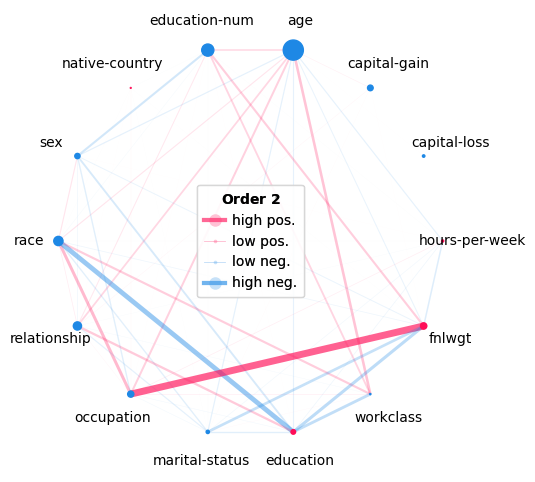

In [10]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

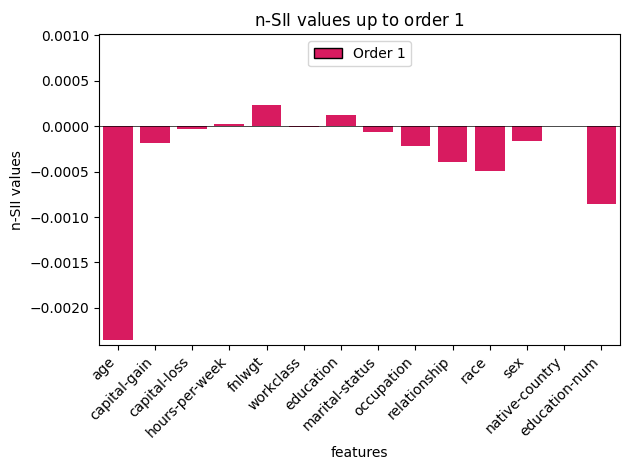

In [11]:
_ = shapiq.stacked_bar_plot(
    n_shapley_values_pos={1: np.array([0 if x < 0 else x for x in interaction_values.get_n_order_values(1)])},
    n_shapley_values_neg={1: np.array([0 if x > 0 else x for x in interaction_values.get_n_order_values(1)])},
    feature_names=X.columns,
)

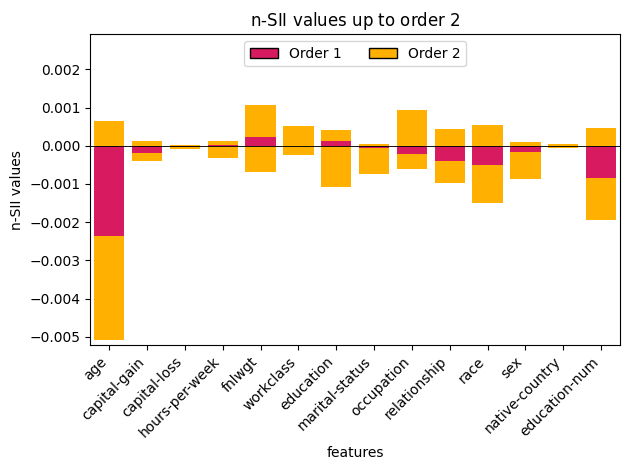

In [12]:
_ = shapiq.stacked_bar_plot(
    n_shapley_values_pos={1: np.array([0 if x < 0 else x for x in interaction_values.get_n_order_values(1)]),
                          2: interaction_values.get_n_order_values(2).clip(min=0).sum(axis=0)},
    n_shapley_values_neg={1: np.array([0 if x > 0 else x for x in interaction_values.get_n_order_values(1)]),
                          2: interaction_values.get_n_order_values(2).clip(max=0).sum(axis=0)},
    feature_names=X.columns,
    n_sii_max_order=2
)